Preprocesses Hansen continuous forest mask from 2000-2024 
(generated using GEE javascript API https://code.earthengine.google.com/33b627316962cec86c281588aee29cfa)
- rescales and reprojects to match the predictor and predictand data set

In [1]:
# import packages
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import os
import glob
import rasterio
import re
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from rasterio.enums import Resampling 


# -----------------------------
# 1. Load the monthly LAI dataset (NetCDF)
# -----------------------------
lai_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/modisLAI/MODIS_LAI_monthly.nc"
ds_lai = xr.open_dataset(lai_path)

# Set spatial dims and CRS
ds_lai = ds_lai.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
ds_lai = ds_lai.rio.write_crs("EPSG:4326", inplace=True)  # assuming it's lat/lon WGS84

print(ds_lai)
# print(ds_lai.time.values)  # check dates
da = ds_lai['lai']
da.rio  # This will attach rioxarray functionality if not already attached

# Check the CRS
print(da.rio.crs)
print(da.dims)
# Print all timestamps
print(ds_lai.time.values)

<xarray.Dataset> Size: 23MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
    spatial_ref  int64 8B 0
Data variables:
    lai          (time, lat, lon) float64 23MB ...
Attributes:
    citation:       [1] Lin, W., Yuan, H., Dai, Y. et al., 2022. Reprocessed ...
    contact:        Yuan, Hua (yuanh25@mail.sysu.edu.cn)
    creation_date:  20221119
    institution:    Land-Atmosphere Interaction Research Group at Sun Yat-sen...
    title:          LAI data sets for land surface and climate modelling
EPSG:4326
('time', 'lat', 'lon')
['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'
 '2002-07-31T00:00:00.00

In [2]:
path = "/home/jovyan/large_files/climLai_merged.nc"
ds_combined = xr.open_dataset(path)

# Set spatial dims and CRS
ds_lai = ds_lai.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
# ds_lai = ds_lai.rio.write_crs("EPSG:4326", inplace=True)  # assuming it's lat/lon WGS84

print(ds_combined)
# print(ds_lai.time.values)  # check dates
da = ds_combined['lai']
da.rio  # This will attach rioxarray functionality if not already attached

# Check the CRS
print(da.rio.crs)
print(da.dims)
# Print all timestamps
print(ds_combined.time.values)

<xarray.Dataset> Size: 181MB
Dimensions:      (time: 228, lat: 107, lon: 116)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2002-01-31 2002-02-28 ... 2020-12-31
  * lat          (lat) float32 428B -9.125 -9.175 -9.225 ... -14.38 -14.43
  * lon          (lon) float32 464B -73.47 -73.42 -73.38 ... -67.78 -67.72
Data variables:
    spatial_ref  int64 8B ...
    tmmx         (time, lat, lon) float64 23MB ...
    tmmn         (time, lat, lon) float64 23MB ...
    pr           (time, lat, lon) float64 23MB ...
    pdsi         (time, lat, lon) float64 23MB ...
    def          (time, lat, lon) float64 23MB ...
    vpd          (time, lat, lon) float64 23MB ...
    soil         (time, lat, lon) float64 23MB ...
    lai          (time, lat, lon) float64 23MB ...
None
('time', 'lat', 'lon')
['2002-01-31T00:00:00.000000000' '2002-02-28T00:00:00.000000000'
 '2002-03-31T00:00:00.000000000' '2002-04-30T00:00:00.000000000'
 '2002-05-31T00:00:00.000000000' '2002-06-30T00:00:00.000000000'
 '

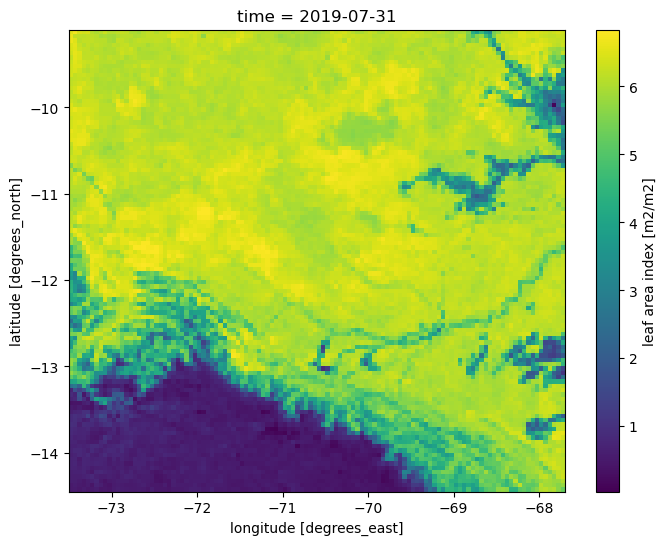

In [3]:
ds_combined.lai.isel(time=210).plot(figsize=(8,6))

In [11]:
# preprocessed using https://code.earthengine.google.com/33b627316962cec86c281588aee29cfa
clip_tif = rio.open_rasterio("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansenMask_mode_27m_v2.tif")

# CRS
print("CRS:", clip_tif.rio.crs)

# Affine transform
transform = clip_tif.rio.transform()
print("Affine transform:", transform)

# Pixel size (resolution)
res_x, res_y = clip_tif.rio.resolution()
print("Pixel size:", res_x, res_y)

# Bounds (xmin, ymin, xmax, ymax)
print("Bounds:", clip_tif.rio.bounds())

# Width / Height in pixels
print("Width (px):", clip_tif.rio.width)
print("Height (px):", clip_tif.rio.height)

CRS: EPSG:4326
Affine transform: | 0.00, 0.00,-73.49|
| 0.00,-0.00,-9.11|
| 0.00, 0.00, 1.00|
Pixel size: 0.00025 -0.00025
Bounds: (-73.48975, -14.471249999999998, -67.72175, -9.106499999999997)
Width (px): 23072
Height (px): 21459


In [12]:
# raster_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansenMask_mode_27m_v2.tif"
# # raster_path = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansen_datamask.tif"
# band_number = 1

# # Open raster using rasterio
# with rasterio.open(raster_path) as src:
#     raster = src.read(1)          # read first band
#     transform = src.transform      # georeference info (optional)
#     nodata = src.nodata
#     print("Band count:", src.count)
#     print("Band descriptions:", src.descriptions)
#     print("Metadata:", src.meta)
    

# # Mask nodata values
# raster = np.ma.masked_equal(raster, nodata)

# # Define your color palette
# palette = [
#     '#1a3678', '#2955bc', '#5699ff', '#8dbae9', '#acd1ff', '#caebff', '#e5f9ff',
#     '#fdffb4', '#ffe6a2', '#ffc969', '#ffa12d', '#ff7c1f', '#ca531a', '#ff0000',
#     '#ab0000'
# ]

# cmap = ListedColormap(palette)

# # Visualize
# plt.figure(figsize=(10, 6))
# plt.imshow(raster, cmap=cmap)
# plt.colorbar(label='Raster values')
# plt.title('Raster Visualization')
# plt.axis('off')
# plt.show()

EPSG:4326
| 0.05, 0.00,-73.50|
| 0.00,-0.05,-9.10|
| 0.00, 0.00, 1.00|
(107, 116)


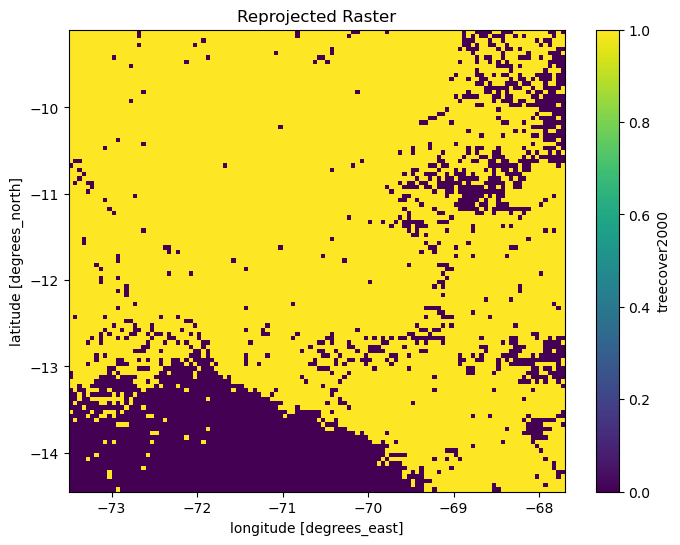

In [13]:
if ds_combined.rio.crs is None:
    ds_combined = ds_combined.rio.write_crs("EPSG:4326")

target_crs = ds_combined.rio.crs
target_transform = ds_combined.rio.transform()
target_shape = ds_combined.rio.shape

print(target_crs)
print(target_transform)
print(target_shape)

clip_matched = clip_tif.rio.reproject(
    dst_crs=target_crs,
    transform=target_transform,
    shape=target_shape,
    resampling=Resampling.nearest   # ← correct
)

clip_matched.squeeze().plot(figsize=(8, 6))
plt.title("Reprojected Raster")
plt.show()

In [14]:
clip_matched.rio.to_raster("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/hansenMask_mode_50m_v2.tif")